In [2]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import load_iris, load_diabetes, load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import scipy

rng = np.random.RandomState(123)
tf.random.set_seed(42)

In [3]:
def resort_data(X_test, *args):

    X_test, *args = zip(*sorted(zip(X_test, *args)))

    X_test = np.array(X_test)
    
    args = [np.array(arg) for arg in args]

    return X_test, *args

In [4]:
def load_1D_dataset(N_total=200, test_set_proportion=0.2):

    def func(x):
        return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

    N_tot = N_total  # Number of total input points (training and test)

    X = rng.rand(N_tot, 1) * 2 - 1  # X values
    Y = func(X) + 0.2 * rng.randn(N_tot, 1)  # Noisy Y values

    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X,
        Y,
        test_size=test_set_proportion,
        random_state=88,
        shuffle=True
        )

    X_test, Y_test = resort_data(X_test, Y_test)

    return  X_train, X_test, Y_train, Y_test




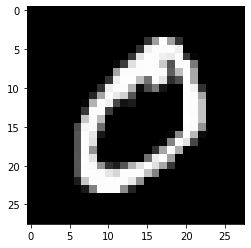

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [6]:

def load_dataset(dataset="1D"):

    if dataset=="1D":
        x_train, x_test, y_train, y_test = load_1D_dataset()
        return x_train, x_test, y_train, y_test
    elif dataset=="mnist":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        assert x_train.shape == (60000, 28, 28)
        assert x_test.shape == (10000, 28, 28)
        assert y_train.shape == (60000,)
        assert y_test.shape == (10000,)
        x_train = x_train.reshape(60000, 784)/255
        x_test = x_test.reshape(10000, 784)/255
        
    else:
        if dataset=="diabetes":
            data = load_diabetes()
        if dataset=="breast":
            data = load_breast_cancer()
        if dataset=="iris":
            data = load_iris()
        if dataset=="digits":
            data = load_digits()


        y = data["target"]
        #y = np.array([float(y_one) for y_one in y])
        X = data["data"]
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


        
        # print(C)


    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    N = len(y_train)

    if dataset== "breast" or "iris" or "digits" or "mnist":

        C = len(unique_labels(y_train))
        y_hot = np.zeros((N, C))
        
        y_hot = OneHotEncoder(handle_unknown='ignore').fit_transform(y_train).toarray()

        # print("poo")

        #y_hot = y_hot.reshape(-1, 1)

        return x_train, x_test, y_hot, y_test

    else:

        D = len(x_train[0])

        return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = load_dataset(dataset="mnist")

plt.imshow(x_train[1].reshape(28, 28), cmap='gray')
plt.show()

print(type(y_train[1]))
print(type(x_train[1]))
print(type(x_train[1,1]))



In [7]:
def LPD_fn(Y_predict_mu, Y_predict_var, Y_test):
    """
        Loss function - negative log validation density loss.

    Args:
        - X_train: Input values for training dataset
        - Y_train: Output values for training dataset
        - X_test: Input values for test dataset

    Returns:
        - Y_predict_mu: Predicted output values for inputs X_test
        - Y_predict_var: The variances for Y_predict_mu

    
    """

    term_1 = np.log(Y_predict_var)
    term_2 = ((Y_predict_mu - Y_test)**2)/(Y_predict_var)
    term_3 = np.log(2*np.pi)
    return np.sum(-0.5*(term_1+term_2+term_3))

def MSE(Y_predict_mu, Y_predict_var, Y_test):
    return np.mean((Y_predict_mu - Y_test)**2)

In [21]:
M = 1000

Z_SGPR = x_train[:M, :].copy()

kernel_GPR = gpflow.kernels.SquaredExponential(lengthscales=np.ones(len(x_train[0])))

C = len(unique_labels(y_train))
kernel = gpflow.kernels.SharedIndependent(
    gpflow.kernels.SquaredExponential(lengthscales=np.ones(len(x_train[0]))), output_dim=C )


m = gpflow.models.SGPR(
    data=(x_train, y_train),
    inducing_variable=Z_SGPR,
    kernel=kernel_GPR,
    num_latent_gps=C
    )
    
gpflow.set_trainable(m.inducing_variable, False)

m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,"(784,)",float64,"[1., 1., 1...."
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(1000, 784)",float64,"[[0., 0., 0...."


[-734346.8043670773, -465629.6083573784, -189022.91042077442, -165670.3558272061, -165147.03398892912, -163916.07222222217, -161994.4425560226, -161337.50992755772, -160954.92141195695, -160773.34841705207, -160680.43041513336, -160634.31767261255, -160611.1687415322, -160599.60140534025, -160593.7232951912, -160593.34473014448, -160590.5764070407, -160589.0669517574, -160588.32678403344, -160587.94884313626, -160587.76679541782, -160587.67817376764, -160587.63477533223, -160587.61331035697, -160587.6026447513, -160587.5973286751, -160587.59732861014]


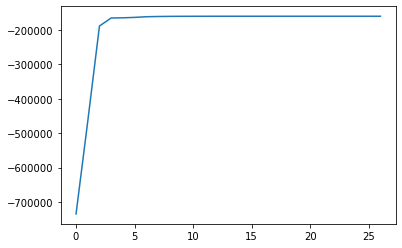

In [22]:
opt = gpflow.optimizers.Scipy()

logs = []

def log_opt(x):
    logs.append(float(m.elbo()))
    #logs.append(float(m.log_marginal_likelihood()))



log = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=300),
    callback=log_opt,
    )

print(logs)
plt.plot(logs)

In [23]:
m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.7690259751815748e-09
SGPR.kernel.lengthscales,Parameter,Softplus,,True,"(784,)",float64,"[1., 1., 1...."
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.10000004861036332
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(1000, 784)",float64,"[[0., 0., 0...."


In [24]:
y_pred, var = m.predict_y(x_test)


In [25]:
print(np.shape(x_test))
print(np.shape(y_test))
print(np.shape(y_pred))
print(np.shape(x_train))
print(np.shape(y_train))
y_pred_labels = np.argmax(y_pred, axis=1).reshape(-1, 1)


(10000, 784)
(10000, 1)
(10000, 10)
(60000, 784)
(60000, 10)


In [26]:


print(accuracy_score(y_test, y_pred_labels))

0.8576


In [27]:


print(y_pred_labels[:20].reshape(1,-1))
print(y_test[:20].reshape(1,-1))

[[7 2 1 0 4 1 9 9 4 9 0 6 9 0 1 3 9 7 5 4]]
[[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]]
